# Import Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load Data

In [3]:
link = "https://drive.google.com/file/d/1aVIPePUBUWzrbIW-3PAjLw5jh--F_fdH/view"
path = "https://drive.google.com/uc?id=" + link.split("/")[-2]
df = pd.read_csv(path)

# Verify shapes
print("Data Shape:", df.shape)

Data Shape: (44, 5)


# Data Preview and Info

In [4]:
# Display few rows of dataset
print("Data Preview:")
display(df.head())

Data Preview:


,No.,Profit,RnD,Adm,Marketing
0,1,192,165,137,472
1,2,192,163,151,444
2,3,191,153,101,408
3,4,183,144,119,383
4,5,166,142,91,366


In [5]:
df.columns = (
    df.columns
    .str.strip()
)

# Display information about the DataFrames
print("\nTrain Data Info:")
df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   No.        44 non-null     int64
 1   Profit     44 non-null     int64
 2   RnD        44 non-null     int64
 3   Adm        44 non-null     int64
 4   Marketing  44 non-null     int64
dtypes: int64(5)
memory usage: 1.8 KB


## Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **dataset** contains 44 samples with 5 columns, including the target variable `Profit`.

**Feature Overview**  
   - Both datasets include all important attributes:  
     - **Numerical features:** `RnD`, `Adm`, `Marketing`.
   - The target variable is numerical.

**Data Completeness**  
   - The dataset have **no missing values**.
   - Data types are appropriate: numerical features is int64.

In [6]:
df.drop(columns = ["No."], inplace = True)
print("Train Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df.describe().T.style.background_gradient(cmap=cm))

Train Data describe:


,count,mean,std,min,25%,50%,75%,max
Profit,44.000000,121.045455,33.271927,70.000000,97.000000,110.500000,144.500000,192.000000
RnD,44.000000,83.227273,40.267630,16.000000,59.500000,76.500000,116.250000,165.000000
Adm,44.000000,122.090909,27.446200,51.000000,102.500000,123.000000,145.250000,183.000000
Marketing,44.000000,231.409091,109.308464,0.000000,146.250000,239.500000,303.500000,472.000000


## Descriptive Insights – Numerical Features

* **Profit**

  * Mean: \~121
  * Range: 70 to 192
  * Distribution is relatively narrow, with a standard deviation (\~33) much smaller than the mean → stable data, low dispersion.

* **R\&D (RnD)**

  * Mean: \~83
  * Range: 16 to 165
  * Standard deviation (\~40) is quite high relative to the mean, indicating notable differences in R\&D spending across companies.

* **Administration (Adm)**

  * Mean: \~122
  * Range: 51 to 183
  * Standard deviation (\~27) is low → distribution is concentrated, with little variability.

* **Marketing**

  * Mean: \~231, the highest among cost variables
  * Range: 0 to 472 (min = 0 indicates some companies **spent nothing on Marketing**)
  * Standard deviation (\~109) is very large, reflecting strong dispersion → some companies invest heavily in Marketing, while others invest very little.

**Key Observations**

1. **Profit** is distributed quite evenly within 70–192, with no extreme outliers.
2. **R\&D** shows significant variation among companies → some spend very little, while others spend heavily.
3. **Administration** is relatively uniform, without large differences.
4. **Marketing** shows the greatest disparity, with extreme values ranging from 0 to 472.

# Data Quality Checks

## Missing Value

In [10]:
def displayNULL(df, dataset_name=None):
    total_rows = len(df)

    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ["Feature", "Missing_Count"]
    missing_df = missing_df[missing_df["Missing_Count"] > 0]
    missing_df["Missing_%"] = (missing_df["Missing_Count"] / total_rows * 100).round(2)
    missing_df = missing_df.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)

    total_missing = missing_df["Missing_Count"].sum()

    print("=" * 40)
    if dataset_name:
        print(f"🔎 Missing Value Summary for: {dataset_name}")
    else:
        print("🔎 Missing Value Summary:")
    print("=" * 40)

    if total_missing == 0:
        print(f"✅ No missing values detected in {total_rows:,} rows.")
    else:
        try:
            from tabulate import tabulate
            print(tabulate(missing_df, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "left", "left")))
        except ImportError:
            print(missing_df.to_string(index=False))

        print(f"\n⚠️  Total missing values: {total_missing:,} out of {total_rows:,} rows.")

print("Missing value in the dataset: ")
displayNULL(df, dataset_name="Data Set")

Missing value in the dataset: 
🔎 Missing Value Summary for: Data Set
✅ No missing values detected in 44 rows.


## Checking duplicate Value

In [11]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)

    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)

    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }
    print()

🔍 Data Duplicate Analysis
✅ No duplicates found in 44 rows



## Checking Outlier Value

In [13]:
def checking_outlier(list_feature, df, dataset_name):
    print("=" * 40)
    print(f"🔍 {dataset_name} Checking outlier")
    print("=" * 40)
    outlier_info = []

    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        if len(outliers) > 0:
            outlier_info.append({
                "Feature": feature,
                "Outlier Count": len(outliers),
                # "Outlier Detail": outliers.tolist()
            })

    if len(outlier_info) == 0:
        print("No outliers detected in the given features.")
    else:
        return pd.DataFrame(outlier_info)

num_features = ["Profit", "RnD", "Adm", "Marketing"]
checking_outlier(list_feature=num_features, df=df, dataset_name="Data")

🔍 Data Checking outlier
No outliers detected in the given features.


# Visualize

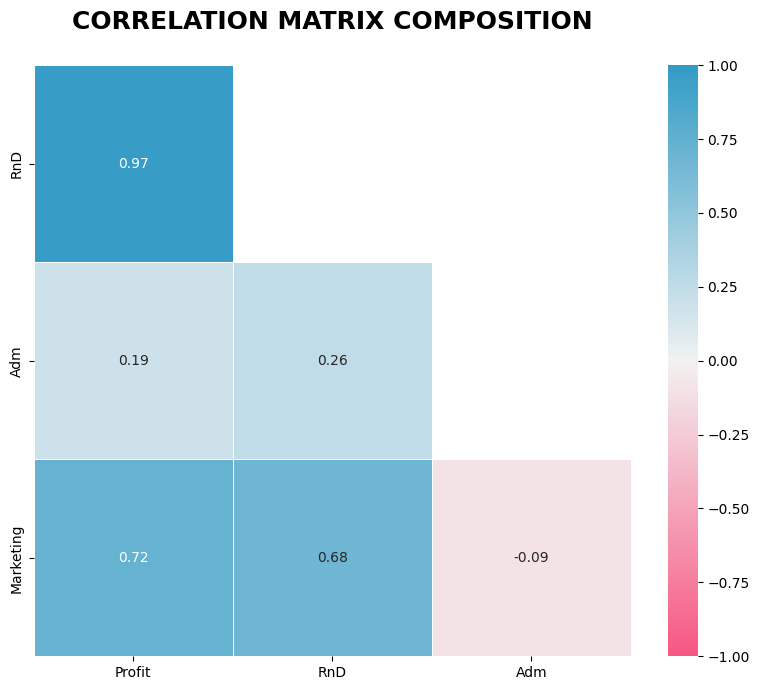

In [15]:
corr_matrix = df.corr(numeric_only=True)
# one_like can build a matrix of boolean(True, False) with the same shape as our data
ones_corr = np.ones_like(corr_matrix, dtype=bool)
mask = np.triu(ones_corr)
adjusted_mask = mask[1:, :-1]
adjusted_cereal_corr = corr_matrix.iloc[1:, :-1]

fig, ax = plt.subplots(figsize = (8, 7))
# That method uses HUSL colors, so you need hue, saturation, and lightness.
# I used hsluv.org to select the colors of this chart.
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(data=adjusted_cereal_corr, mask=adjusted_mask,
            annot=True, fmt=".2f", cmap=cmap,
            vmin=-1, vmax=1, linecolor="white", linewidths=0.5)

title = "CORRELATION MATRIX COMPOSITION\n"
ax.set_title(title, loc="center", fontsize=18, weight="bold");
plt.tight_layout()
plt.show()

## **Correlation with Profit**

* **R\&D (0.97)**: shows a very strong positive correlation with Profit, suggesting that R\&D spending is the most important factor influencing profitability.
* **Marketing (0.72)**: also has a strong positive correlation with Profit, indicating that higher Marketing expenses are generally associated with higher profits.
* **Administration (0.19)**: only shows a weak correlation, implying little to no impact on Profit.

**Correlation among Independent Variables**

* **R\&D and Marketing (0.68)**: relatively strong correlation → companies that invest heavily in R\&D also tend to spend more on Marketing.
* **R\&D and Administration (0.26)**: weak correlation.
* **Marketing and Administration (-0.09)**: almost no relationship, with a slightly negative tendency.

**Key Takeaways**

1. **R\&D is the strongest driver** of Profit and can be considered the main explanatory factor in predictive modeling.
2. **Marketing also plays a strong role**, though it may introduce multicollinearity since it is correlated with R\&D as well.
3. **Administration has little to no relationship** with Profit and could potentially be excluded when building regression models.

**Conclusion:** In this dataset, profitability is mainly driven by **R\&D and Marketing investments**, while **Administration expenses show minimal impact**.

# Sử dụng data đã scale với 3 feature

## Data Pre-processing

In [67]:
X = df.drop("Profit", axis=1)
y = df["Profit"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [68]:
list_feature_num_stand = ["RnD", "Adm", "Marketing"]

num_stand_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num_standard", num_stand_transformer, list_feature_num_stand)
])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_standard',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['RnD', 'Adm', 'Marketing'])])

In [69]:
X_train_prepared = preprocessor.transform(X_train)
X_val_prepared = preprocessor.transform(X_val)
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num_standard__RnD', 'num_standard__Adm', 'num_standard__Marketing']

## Modeling

In [70]:
# Initialize & train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [71]:
# Function to evaluate regression models
def evaluate_model(model, X_train, X_val, y_train, y_val):
    RESET = "\033[0m"
    BLUE = "\033[94m"
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    y_val_real = y_val
    y_pred_real = y_pred

    # Metric: R²
    r2 = r2_score(y_val_real, y_pred_real)
    print(f"Model: {model.__class__.__name__}{RESET}")
    print(f"Coefficient of Determination (R²): {BLUE}{r2:.2f}{RESET}")
    print("-" * 80)

    # Metric: MAE
    mae = mean_absolute_error(y_val_real, y_pred_real)
    print(f"Mean Absolute Error (MAE): {BLUE}{mae:.2f}{RESET}")
    print("-" * 80)

    # Metric: MSE
    mse = mean_squared_error(y_val_real, y_pred_real)
    print(f"Mean Squared Error (MSE): {BLUE}{mse:.2f}{RESET}")
    print("-" * 80)

    # Metric: RMSE
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {BLUE}{rmse:.2f}{RESET}")
    print("-" * 80)

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    # ----- Plot 1: Predicted vs. Actual -----
    ax[0].scatter(y_val_real, y_pred_real, alpha=0.4, color="royalblue")
    ax[0].plot(
        [y_val_real.min(), y_val_real.max()],
        [y_val_real.min(), y_val_real.max()],
        "r--", lw=2, label="Perfect Prediction (y=x)"
    )
    ax[0].set_xlabel("Actual Values")
    ax[0].set_ylabel("Predicted Values")
    ax[0].set_title("Predicted vs. Actual (Validation Set)", weight="bold", pad=20)
    ax[0].legend()
    ax[0].grid(True, alpha=0.2)

    # ----- Plot 2: Residual Plot -----
    residuals = y_val_real - y_pred_real
    ax[1].scatter(y_val_real, residuals, alpha=0.5)
    ax[1].axhline(0, color="red", linestyle="--", lw=2)
    ax[1].set_xlabel("Actual Values")
    ax[1].set_ylabel("Prediction Error (Residuals)")
    ax[1].set_title("Residual Plot", weight="bold", pad=20)
    ax[1].grid(True, alpha=0.2)

    # Optimize layout
    plt.tight_layout()
    plt.show()

Model: LinearRegression
Coefficient of Determination (R²): 0.89
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 8.59
--------------------------------------------------------------------------------
Mean Squared Error (MSE): 94.07
--------------------------------------------------------------------------------
Root Mean Squared Error (RMSE): 9.70
--------------------------------------------------------------------------------


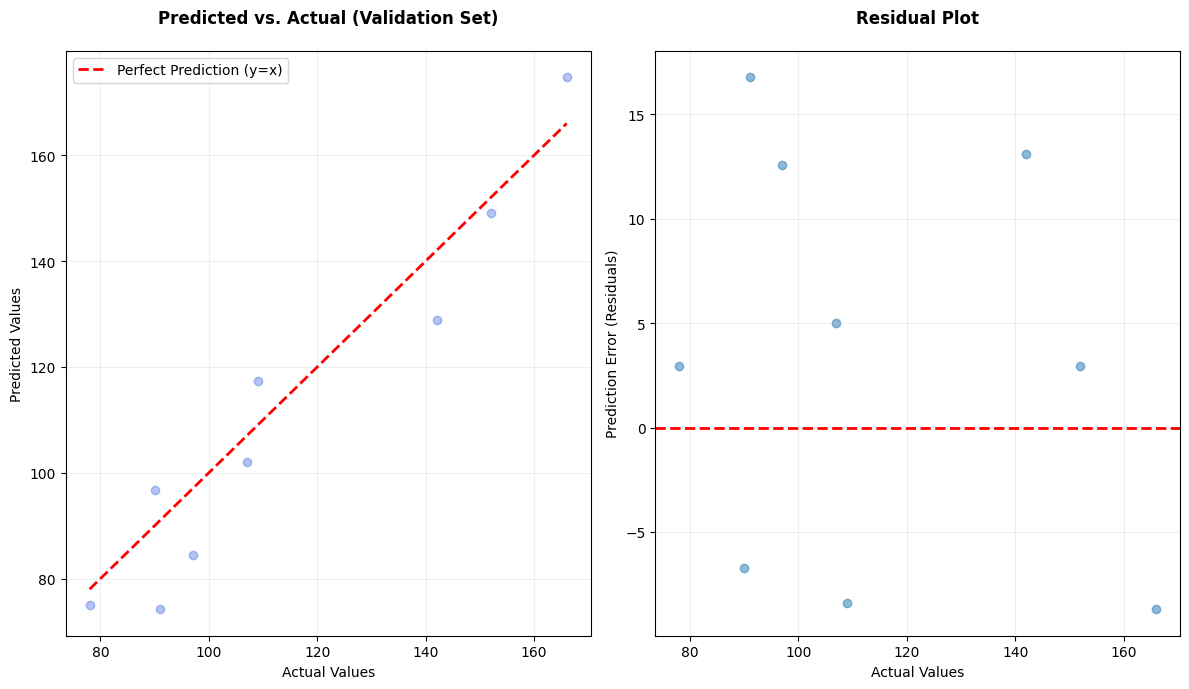

In [72]:
# Evaluate
evaluate_model(model=lin_reg, X_train=X_train_prepared, X_val=X_val_prepared, y_train=y_train, y_val=y_val)

# Sử dụng feature Marketing

## Data Pre-processing

In [73]:
X = df.drop(columns=["RnD", "Adm", "Profit"], axis=1)
y = df["Profit"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

## Modeling

In [74]:
# Initialize & train the model
lin_reg_a = LinearRegression()
lin_reg_a.fit(X_train, y_train)

LinearRegression()

Model: LinearRegression
Coefficient of Determination (R²): 0.55
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 17.55
--------------------------------------------------------------------------------
Mean Squared Error (MSE): 383.28
--------------------------------------------------------------------------------
Root Mean Squared Error (RMSE): 19.58
--------------------------------------------------------------------------------


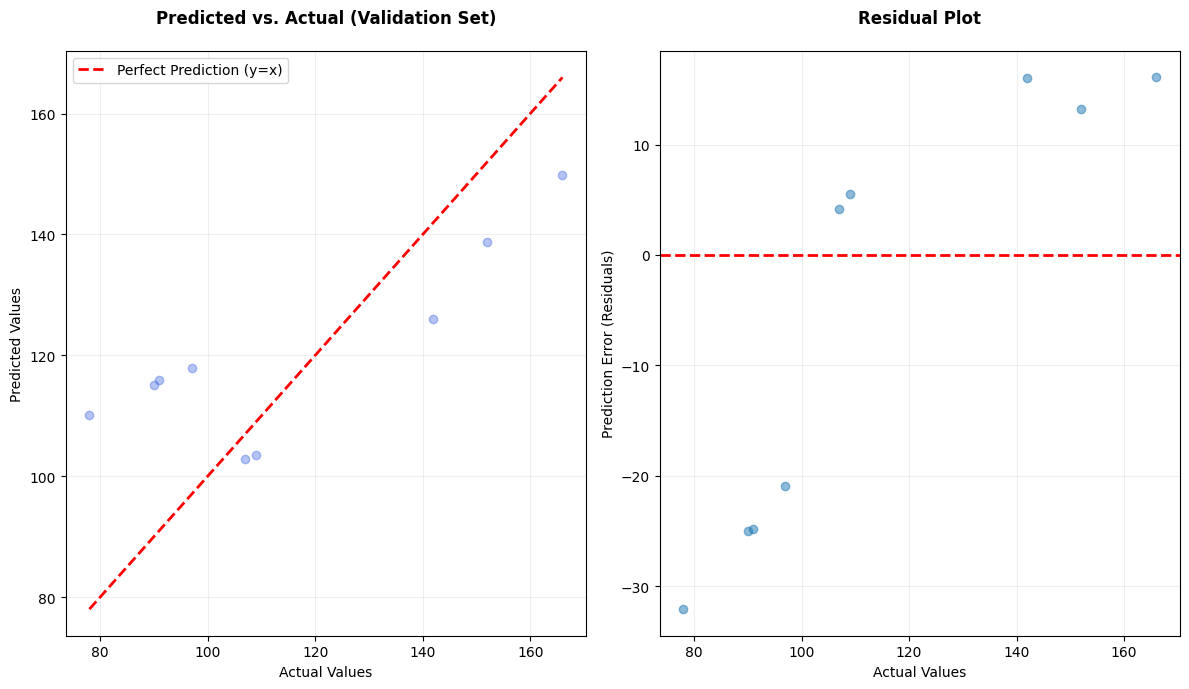

In [75]:
# Evaluate
evaluate_model(model=lin_reg_a, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

# Sử dụng feature Adm

## Data Pre-processing

In [76]:
X = df.drop(columns=["RnD", "Marketing", "Profit"], axis=1)
y = df["Profit"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

## Modeling

In [77]:
# Initialize & train the model
lin_reg_b = LinearRegression()
lin_reg_b.fit(X_train, y_train)

LinearRegression()

Model: LinearRegression
Coefficient of Determination (R²): -0.09
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 27.14
--------------------------------------------------------------------------------
Mean Squared Error (MSE): 932.36
--------------------------------------------------------------------------------
Root Mean Squared Error (RMSE): 30.53
--------------------------------------------------------------------------------


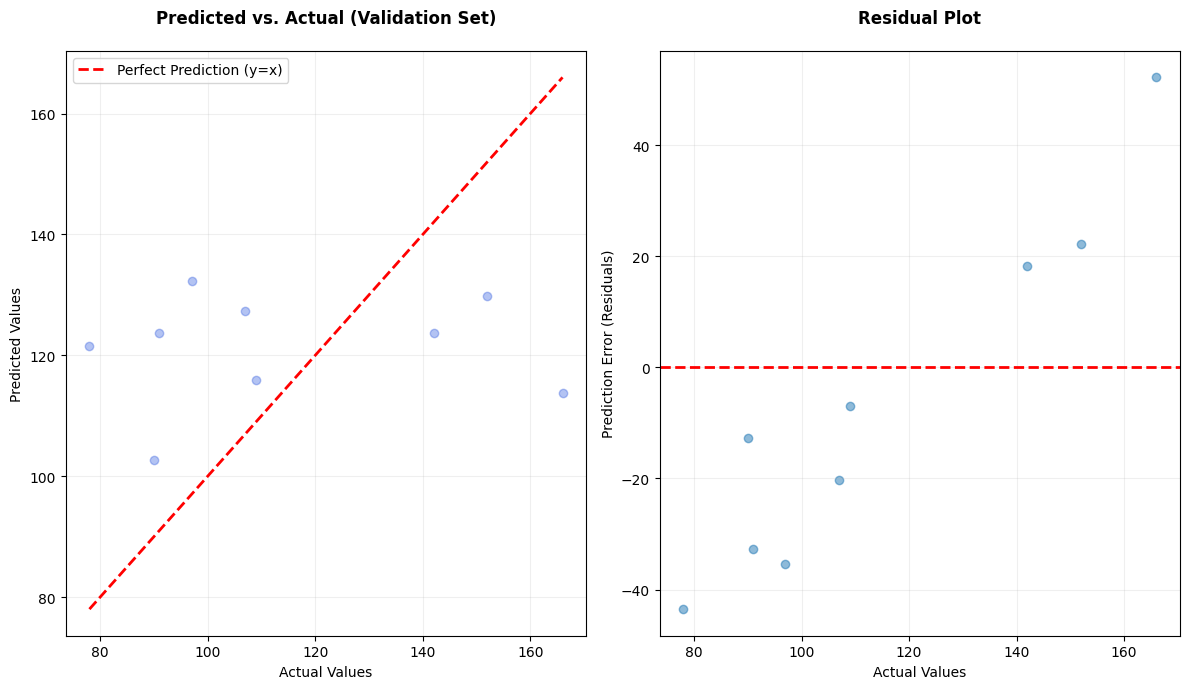

In [78]:
# Evaluate
evaluate_model(model=lin_reg_b, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

# Sử dụng cả 3 feature (Marketing, Adm, RnD)

## Data Pre-processing

In [79]:
X = df.drop(columns=["Profit"], axis=1)
y = df["Profit"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

## Modeling

In [80]:
# Initialize & train the model
lin_reg_c = LinearRegression()
lin_reg_c.fit(X_train, y_train)

LinearRegression()

Model: LinearRegression
Coefficient of Determination (R²): 0.89
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 8.59
--------------------------------------------------------------------------------
Mean Squared Error (MSE): 94.07
--------------------------------------------------------------------------------
Root Mean Squared Error (RMSE): 9.70
--------------------------------------------------------------------------------


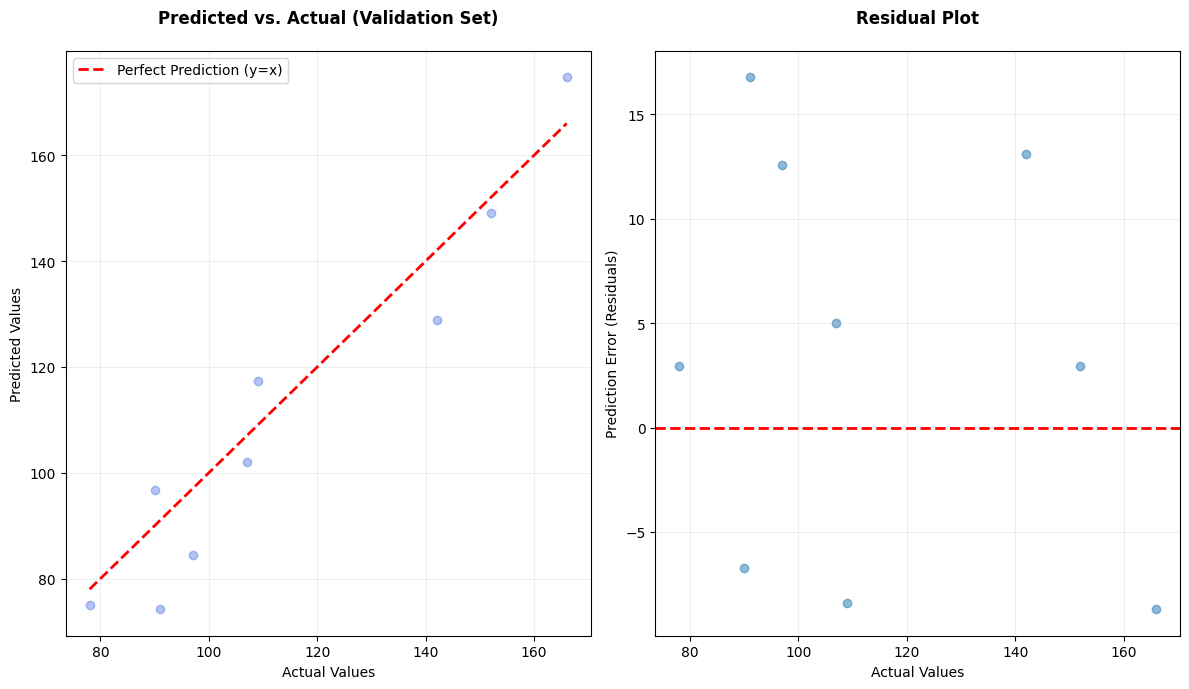

In [81]:
# Evaluate
evaluate_model(model=lin_reg_c, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val)

# Conclusion

| Index | Model Type         | Feature                  | Transformation (None, scale, oversampling, etc.) | R² Score | MAE   | MSE    | RMSE  |
|-------|--------------------|--------------------------|--------------------------------------------------|----------|-------|--------|-------|
| 1     | Linear Regression  | Scale (RnD, Adm, Marketing) | None                                             | 0.89     | 8.59  | 94.07  | 9.70  |
| 2     | Linear Regression  | Marketing                | None                                             | 0.55     | 17.55 | 383.28 | 19.58 |
| 3     | Linear Regression  | Adm                      | None                                             | -0.09    | 27.14 | 932.36 | 30.53 |
| 4     | Linear Regression  | RnD, Adm, Marketing      | None                                             | 0.89     | 8.59  | 94.07  | 9.70  |


* **Best model**: Linear Regression with all three features (R\&D, Administration, Marketing) → **R² = 0.89, RMSE ≈ 9.7**
* **Use all three features (R\&D, Marketing, Administration). Apply scaling for better interpretability and compatibility with advanced models.**